# Data Science Demo: predicting Crime resolution in San Francisco 

The City of San Francisco publishes historical crime events on their http://sfdata.gov website. 

I have loaded this dataset into HIVE. Let's use Spark to do some fun stuff with it!

## Setting Up SparkR

First we setup SparkR, create a SparkContext as well as a HiveContext to access data from Hive:

In [1]:
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

library(SparkR)
require(ggplot2)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var

The following objects are masked from ‘package:base’:

    colnames, colnames<-, intersect, rank, rbind, sample, subset,
    summary, table, transform

Loading required package: ggplot2


In [2]:
# Create Spark Context
sc = sparkR.init(master="yarn-client", appName="SparkR Demo",
                 sparkEnvir = list(spark.executor.memory="4g", spark.executor.instances="15"))

# Create HiveContext
hc = sparkRHive.init(sc)
sql(hc, "use demo")

Launching java with spark-submit command /usr/hdp/2.3.4.1-10/spark///bin/spark-submit   sparkr-shell /tmp/RtmpgS9r78/backend_port71f962c08568 


DataFrame[result:string]

Let's take a look at the dataset - first 5 rows:

In [3]:
crimes = table(hc, "crimes")
df = head(crimes, 5)
df

  incidentid       category                  description dayofweek   date_str
1  150331521  LARCENY/THEFT  GRAND THEFT FROM A BUILDING Wednesday 04/22/2015
2  150341605        ASSAULT     ATTEMPTED SIMPLE ASSAULT    Sunday 04/19/2015
3  150341605        ASSAULT         THREATS AGAINST LIFE    Sunday 04/19/2015
4  150341605 OTHER OFFENSES           CRUELTY TO ANIMALS    Sunday 04/19/2015
5  150341702   NON-CRIMINAL AIDED CASE, MENTAL DISTURBED    Sunday 04/19/2015
   time district            resolution                         address
1 18:00  BAYVIEW                  NONE          2000 Block of EVANS AV
2 12:15  CENTRAL                  NONE      800 Block of WASHINGTON ST
3 12:15  CENTRAL                  NONE      800 Block of WASHINGTON ST
4 12:15  CENTRAL                  NONE      800 Block of WASHINGTON ST
5 12:03  MISSION EXCEPTIONAL CLEARANCE 1100 Block of SOUTH VAN NESS AV
          longitude         latitude                              location
1 -122.396315619126 37.74781136

## Exploring the Dataset

What are the different types of crime resolutions?

In [4]:
showDF(distinct(select(crimes, "resolution"))) 

+--------------------+
|          resolution|
+--------------------+
|             LOCATED|
|   JUVENILE DIVERTED|
|       ARREST, CITED|
|      NOT PROSECUTED|
|COMPLAINANT REFUS...|
|CLEARED-CONTACT J...|
|      JUVENILE CITED|
|PROSECUTED FOR LE...|
|EXCEPTIONAL CLEAR...|
|     JUVENILE BOOKED|
|           UNFOUNDED|
|   PSYCHOPATHIC CASE|
| JUVENILE ADMONISHED|
|DISTRICT ATTORNEY...|
|PROSECUTED BY OUT...|
|      ARREST, BOOKED|
|                NONE|
+--------------------+


Let's define a crime as 'resolved' if it has any string except "NONE" in the resolution column.

**Question**: How many crimes total in the dataset? How many resolved?

In [5]:
total = count(crimes)
num_resolved = count(filter(crimes, crimes$resolution != 'NONE'))
print(paste0(total, " crimes total, out of which ", num_resolved, " were resolved"))

[1] "1750133 crimes total, out of which 700088 were resolved"


Let's look at the longitude/latitude values in more detail. Spark provides the describe() function to see this some basic statistics of these columns:

In [6]:
c1 = select(crimes, alias(cast(crimes$longitude, "float"), "long"), 
                    alias(cast(crimes$latitude, "float"), "lat")) 
showDF(describe(c1))

+-------+-------------------+-------------------+
|summary|               long|                lat|
+-------+-------------------+-------------------+
|  count|            1750133|            1750133|
|   mean|-122.42263853403858| 37.771270995453996|
| stddev|0.03069515078034428|0.47274630631731845|
|    min|         -122.51364|           37.70788|
|    max|             -120.5|               90.0|
+-------+-------------------+-------------------+


Notice that the max values for longitude (-120.5) and latitude (90.0) seem strange. Those are not inside the SF area. Let's see how many bad values like this exist in the dataset: 

In [7]:
c2 = filter(c1, "lat < 37 or lat > 38")
print(count(c2))
showDF(limit(c2,3))


[1] 143
+------+----+
|  long| lat|
+------+----+
|-120.5|90.0|
|-120.5|90.0|
|-120.5|90.0|
+------+----+


Seems like this is a data quality issue where some data points just have a fixed (bad) value of -120.5, 90.

## Computing Neighborhoods

Now I create a new dataset called crimes2:
1. Without the points that have invalid longitude/latitude
2. I calculate the neighborhood associated with each long/lat (for each crime), using ESRI geo-spatial UDFs
3. Translate "resolution" to "resolved" (1.0 = resolved, 0.0 = unresolved)

In [8]:
sql(hc, "add jar /home/jupyter/notebooks/jars/guava-11.0.2.jar")
sql(hc, "add jar /home/jupyter/notebooks/jars/spatial-sdk-json.jar")
sql(hc, "add jar /home/jupyter/notebooks/jars/esri-geometry-api.jar")
sql(hc, "add jar /home/jupyter/notebooks/jars/spatial-sdk-hive.jar")

sql(hc, "create temporary function ST_Contains as 'com.esri.hadoop.hive.ST_Contains'")
sql(hc, "create temporary function ST_Point as 'com.esri.hadoop.hive.ST_Point'")

cf1 = sql(hc, 
"SELECT  date_str, time, longitude, latitude, resolution, category, district, dayofweek, description
 FROM crimes
 WHERE longitude < -121.0 and latitude < 38.0")
cf2 = repartition(cf1, 50)
registerTempTable(cf2, "cf")

crimes2 = sql(hc, 
"SELECT date_str, time, dayofweek, category, district, description, longitude, latitude,
        if (resolution == 'NONE',0.0,1.0) as resolved,
        neighborho as neighborhood 
 FROM sf_neighborhoods JOIN cf
 WHERE ST_Contains(sf_neighborhoods.shape, ST_Point(cf.longitude, cf.latitude))")

# cache(crimes2)
registerTempTable(crimes2, "crimes2")

DataFrame[result:int]

DataFrame[result:int]

DataFrame[result:int]

DataFrame[result:int]

DataFrame[result:string]

DataFrame[result:string]

In [9]:
showDF(limit(crimes2, 5))

+----------+-----+---------+-------------+--------+--------------------+-----------------+----------------+--------+------------+
|  date_str| time|dayofweek|     category|district|         description|        longitude|        latitude|resolved|neighborhood|
+----------+-----+---------+-------------+--------+--------------------+-----------------+----------------+--------+------------+
|02/26/2015|16:30| Thursday| NON-CRIMINAL|RICHMOND|      FOUND PROPERTY|-122.507892223803|37.7807186482924|     0.0|    Seacliff|
|02/24/2015|10:00|  Tuesday|LARCENY/THEFT|RICHMOND|LICENSE PLATE OR ...| -122.50706596541|37.7807037558799|     0.0|    Seacliff|
|01/02/2015|18:40|   Friday|LARCENY/THEFT|RICHMOND|GRAND THEFT FROM ...|-122.511298876781|37.7759977595559|     0.0|    Seacliff|
|08/18/2014|08:30|   Monday|LARCENY/THEFT|RICHMOND|PETTY THEFT OF PR...|-122.508907927108|37.7807278478539|     0.0|    Seacliff|
|04/13/2014|15:00|   Sunday|LARCENY/THEFT|RICHMOND|GRAND THEFT FROM ...|-122.513642064265|

**Question:** what is the percentage of crimes resolved in each neighborhood?

In [10]:
ngrp = groupBy(crimes2, "neighborhood")
df = summarize(ngrp, pres = avg(crimes2$resolved), count = n(crimes2$resolved))
df_sorted = arrange(df, desc(df$pres))
head(df_sorted, 10)

            neighborhood      pres  count
1  Downtown/Civic Center 0.5718149 285122
2                Mission 0.5021143 190606
3                Bayview 0.4725739 119412
4         Haight Ashbury 0.4458685  41898
5       Golden Gate Park 0.4154171  15606
6        South of Market 0.3928699 241230
7             Ocean View 0.3848783  30724
8         Bernal Heights 0.3728814  38881
9              Excelsior 0.3717961  40810
10         Outer Mission 0.3685316  37123

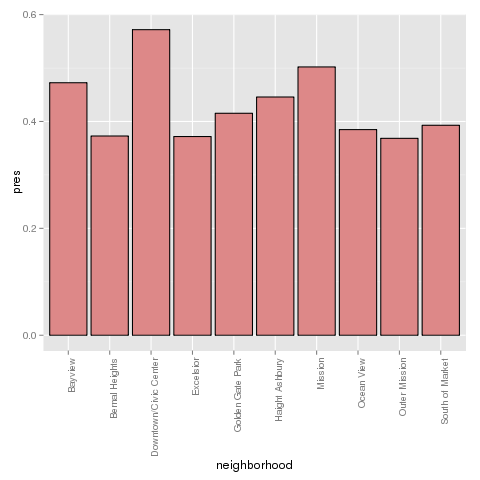

In [11]:
ggplot(data=take(df_sorted, 10), aes(x=neighborhood, y=pres)) + 
       geom_bar(colour="black", stat="identity", fill="#DD8888") + guides(fill=FALSE) +
       theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [12]:
dfl = collect(df)

Using the R leaflet package I draw an interactive map of San Francisco, and color-code each neighborhood with the percent of resolved crimes:

In [13]:
require(leaflet)
require(htmlwidgets)
library(IRdisplay)
library(jsonlite)

sf_lat = 37.77
sf_long = -122.4

geojson <- readLines("data/sfn.geojson") %>% paste(collapse = "\n") %>% fromJSON(simplifyVector = FALSE)

pal <- colorQuantile("OrRd", dfl$pres, n=7)
geojson$features <- lapply(geojson$features, function(feat) {
      feat$properties$style <- list(fillColor = pal(dfl[dfl$neighborhood==feat$properties$neighborho, "pres"]))
      feat
})

m <- leaflet() %>%
     setView(lng = sf_long, lat = sf_lat, zoom = 12) %>%
     addTiles() %>%
     addGeoJSON(geojson, weight = 1.5, color = "#444444", opacity = 1, fillOpacity = 0.3) %>%
     addLegend("topright", pal = pal, values = dfl$pres, title = "P(resolved)", opacity = 1)

tf = 'map1.html'
saveWidget(m, file = tf, selfcontained = T)
display_html(paste0("<iframe src='", tf, "' width=950 height=600></iframe>"))

Loading required package: leaflet
Loading required package: htmlwidgets


In [14]:
# initial data frame
crimes = sql(hc, "SELECT  cast(SUBSTR(date_str,7,4) as int) as year, 
        cast(SUBSTR(date_str,1,2) as int) as month, 
        cast(SUBSTR(time,1,2) as int) as hour,
        resolved, category, district, dayofweek, description, neighborhood
FROM crimes2
WHERE latitude > 37 and latitude < 38")

trainData = filter(crimes, "year>=2011 and year<=2013")
cache(trainData)
testData = filter(crimes, "year=2014")
cache(testData)
print(paste0("training set has ", count(trainData), " instances"))
print(paste0("test set has ", count(testData), " instances"))

DataFrame[year:int, month:int, hour:int, resolved:double, category:string, district:string, dayofweek:string, description:string, neighborhood:string]

DataFrame[year:int, month:int, hour:int, resolved:double, category:string, district:string, dayofweek:string, description:string, neighborhood:string]

[1] "training set has 426306 instances"
[1] "test set has 150155 instances"


In [15]:
model <- glm(resolved ~ month + hour + category + district + dayofweek + neighborhood, 
             family = "binomial", data = trainData)
summary(model)

$coefficients
                                         Estimate
(Intercept)                          -0.500995597
month                                -0.013698270
hour                                  0.007715841
category_LARCENY/THEFT               -1.966637160
category_OTHER OFFENSES               1.270989783
category_NON-CRIMINAL                -0.246223825
category_ASSAULT                      0.230423056
category_VANDALISM                   -1.396336159
category_DRUG/NARCOTIC                2.355341637
category_WARRANTS                     2.898549300
category_SUSPICIOUS OCC              -1.348106274
category_BURGLARY                    -0.875788725
category_VEHICLE THEFT               -1.987641681
category_MISSING PERSON               1.665890169
category_ROBBERY                     -0.822972194
category_FRAUD                       -1.114991424
category_SECONDARY CODES              0.622131629
category_WEAPON LAWS                  1.869005867
category_TRESPASS                   

In [16]:
# Predict results for test data
pmat <- predict(model, testData)

In [62]:
# Compute precision/recall curve

registerTempTable(pmat, "pmat")
cm = sql(hc, "SELECT prediction, label, COUNT(*) as cnt from pmat GROUP BY prediction, label")

cml = collect(cm)
tp = cml[cml['prediction']==1.0 & cml['label']==1.0, "cnt"]
tn = cml[cml['prediction']==0.0 & cml['label']==0.0, "cnt"]
fp = cml[cml['prediction']==1.0 & cml['label']==0.0, "cnt"]
fn = cml[cml['prediction']==0.0 & cml['label']==1.0, "cnt"]
precision = tp / (tp+fp)
recall = tp / (tp+fn)
accuracy = (tp+tn) / (tp+tn+fp+fn)

print(sprintf("precision = %0.2f, recall = %0.2f, accuracy = %0.2f", precision, recall, accuracy)) 

[1] "precision = 0.74, recall = 0.67, accuracy = 0.79"
